In [1]:
import os
import numpy as np
from scipy.ndimage import laplace
from skimage.io import imread
import matplotlib.pyplot as plt

In [2]:
#log_params = {"A": 11.790409566163314, "mu_m": 0.02348393661706508, "lambda": 2.1454099415518964e-15}
log_params = {"A": 11.813539214813655, "mu_m": 0.02001919118343915, "lambda": -73.01216063634942}
incubation_time = 5.5 * 60 * 60 # 316/60 * 60 * 60
def logistic_growth_rate(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    gr = 4 * mu_m * np.exp(4 * mu_m / A * (l - t) + 2) / (1 + np.exp(4 * mu_m / A * (l - t) + 2))**2
    return gr / 60

def logistic(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    log_B = A / (1 + np.exp(4 * mu_m / A * (l - t) + 2))
    return np.exp(log_B)

In [3]:
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

exp_date = '2023_12_06'
#vector = 'pAAA'
#vector = 'pLPT107&pLPT41'
vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'

#scope_name = 'Ti scope'
scope_name = 'Tweez scope'
pos = 14

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_12_06_10x_1.0x_pLPT20&41_TiTweez_Pos14.ome.tif'

In [4]:
#tf = 316
edt = np.load(os.path.join(path_results,'edt.npy'))#[:tf,:,:]
nt,nx,ny = edt.shape
print(edt.shape)

(216, 1024, 1024)


In [5]:
im = imread(os.path.join(path,fname))
im.shape
im = im[:,:,:,:ph_chn].astype(float)
print(im.shape)

(216, 1024, 1024, 2)


In [6]:
edt = np.pad(edt, ((0,0),(256,256),(256,256)))
im = np.pad(im, ((0,0),(256,256),(256,256),(0,0)))
nt,nx,ny = edt.shape

In [7]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
crop_im = np.zeros((nt,w+2*pad,h+2*pad,2))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    tim = im[t,:,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]
    crop_im[t,:,:] = tim[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad,:]

414 416
(216, 926, 928)


In [8]:
nt,nx,ny = crop_edt.shape
offset = incubation_time / 60 / 10
ntt = nt + int(offset)
crop_edt = np.zeros((ntt,nx,ny))
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
cx,cy = nx/2, ny/2
R = np.sqrt((x-cx)**2 + (y-cy)**2)
for t in range(ntt):
    area = logistic(t * 10 * 60 - offset * 10 * 60, log_params)
    radius = np.sqrt(area / np.pi)
    crop_edt[t,:,:] = radius - R
    tedt = crop_edt[t,:,:]
    tedt[tedt<0] = 0 
    crop_edt[t,:,:] = tedt

In [9]:
def split_image_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width, channels = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size, channels))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for c in range(channels):
                for t in range(nt):
                    blocks[t, i, j, :, :, c] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, c]
    return blocks

def split_edt_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for t in range(nt):
                blocks[t, i, j, :, :] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
    return blocks

edt_blocks = split_edt_into_blocks(crop_edt, 16)
im_blocks = split_image_into_blocks(crop_im, 16)
crop_edt_low = edt_blocks.mean(axis=(3,4))
crop_im_low = im_blocks.mean(axis=(3,4))
print(crop_im_low.shape)


(216, 57, 58, 2)


In [10]:
#from skimage.transform import downscale_local_mean

#print(crop_edt.shape)
#crop_edt_low = np.zeros((ntt,57,57))
#crop_im_low = np.zeros((nt,57,57,2))

#for t in range(ntt):
#    edt_low = downscale_local_mean(crop_edt[t,:,:], (16,16))
#    crop_edt_low[t,:,:] = edt_low

#for t in range(nt):
#    im_low = downscale_local_mean(crop_im[t,:,:], (16,16,1))
#    crop_im_low[t,:,:] = im_low

crop_edt = crop_edt_low
crop_im = crop_im_low
print(crop_edt.shape)
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape

crop_im[crop_edt[int(offset):,:,:]==0] = np.nan

(249, 57, 58)


In [11]:
u0 = np.zeros((nx,ny)) + 1
def dudt(u, t, tmask, phi, kappa, gamma, dx, t0):
    du = np.zeros((nx,ny))
    #du[tmask] += phi * 1 / (1 + np.exp((t - t0) / dt)) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='nearest')
    du += kappa * delu / dx / dx
    #du[tmask] -= gamma * u[tmask] * 1 / (1 + np.exp((t - t0) / dt))
    gr = logistic_growth_rate(t - offset * 10 * 60, log_params)
    du[tmask] -= gamma * u[tmask] * gr
    return du.ravel()

In [12]:
def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

def nhill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx) * (1 + K**n)

def step(x, K):
    return (x > K) * 1

p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp):
    #G -| R -| B
    p = p.reshape((nx,ny,4))
    dpdt = np.zeros_like(p)
    # LacI
    #dpdt[:,:,0] = step(uu, KK0) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = nhill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    dpdt[:,:,0] = hill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    # TetR
    #dpdt[:,:,1] = step(uu, KK1) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = nhill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    dpdt[:,:,1] = hill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    # cI
    #dpdt[:,:,2] = step(uu, KK2) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = nhill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    dpdt[:,:,2] = hill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    # mCFP
    #dpdt[:,:,3] = step(uu, KK3) * alpha4 - gamma_repr * p[:,:,3]
    #dpdt[:,:,3] = nhill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    dpdt[:,:,3] = hill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
    for c in range(4):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()

In [13]:
from scipy.integrate import odeint


def solve_gene_expression(rep00, rep01, rep02, u, alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,4))
    p[0,:,:,0] = rep00
    p[0,:,:,1] = rep01
    p[0,:,:,2] = rep02
    p[0,:,:,3] = rep01
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        dp = dpdt(p[ti,:,:,:], t, tmask>0, u[ti,:,:], alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,4)
        mask[ti+1,:,:] = tmask
    
    #p[:-1,:,:,0] = hill(u, KK0, nn) * p[:-1,:,:,0]
    #p[:-1,:,:,1] = hill(u, KK1, nn) * p[:-1,:,:,1]
    #p[:-1,:,:,2] = hill(u, KK2, nn) * p[:-1,:,:,2]
    #p[:-1,:,:,3] = hill(u, KK2, nn) * p[:-1,:,:,3]
    pmask = np.zeros_like(p) + np.nan
    for c in range(4):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_diffusion(kappa, gamma, dx, dt, t0, ts):
    nt = len(ts)
    print(nt)
    u = np.zeros((nt+1,nx,ny))
    u[0,:,:] = u0
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10),:,:] # crop_edt[0,:,:]
        du = dudt(u[ti,:,:], t, tmask>0, 0, kappa, gamma, dx, t0)
        u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
        mask[ti+1,:,:] = tmask

    umask = np.zeros_like(u) + np.nan
    umask[mask>0] = u[mask>0]
    return umask

In [14]:
rep00,rep01,rep02 = 5,1,1
alpha0,alpha1,alpha2,alpha3 = 1e3,1e3,1e3,1e3
beta0,beta1,beta2 = 0,0,0
K0,K1,K2 = 1e2,1e2,1e2
km0,km1,km2 = 1e-4,1e-4,1e-4
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 2
nn = 2
kappa = 1e-13
gamma = 1
gamma_fp = np.log(2) / (6 * 60 * 60)
gamma_repr = np.log(2) / (1 * 60 * 60)
dx = 16e-6
dt = 10
t0 = 0

ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
pmask = solve_gene_expression(rep00, rep01, rep02, uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

14940
10080


Text(0, 0.5, 'Position (pixels)')

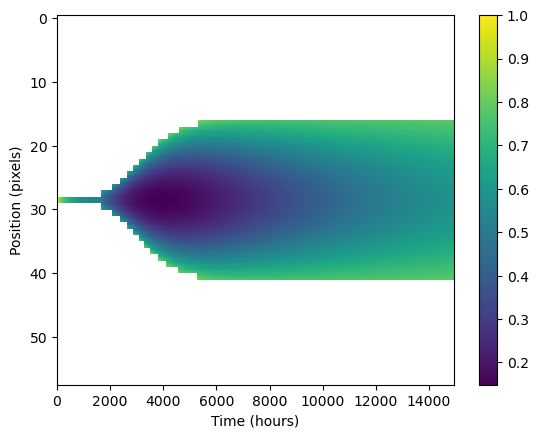

In [15]:
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
#plt.contour(u[10:,int(nx//2),:].transpose(), [0.025])
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')

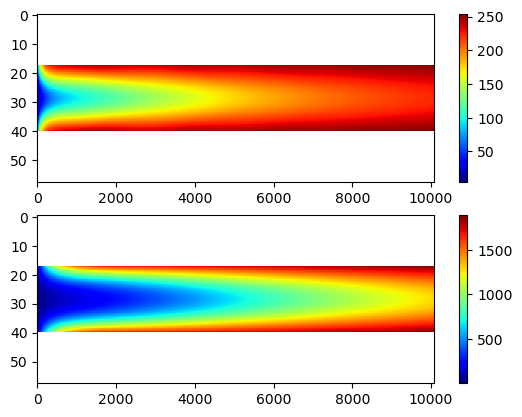

In [16]:
plt.subplot(2,1,1)
plt.imshow(pmask[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(pmask[:,int(nx//2),:,3].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

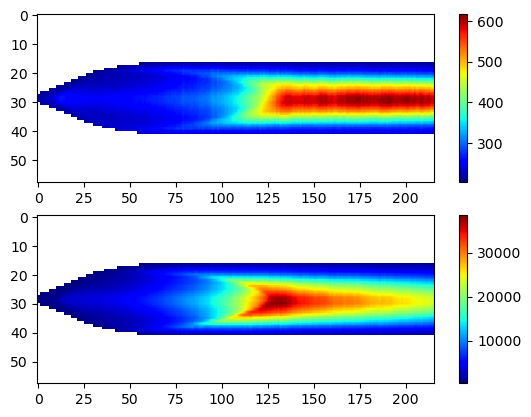

In [17]:
plt.subplot(2,1,1)
plt.imshow(crop_im[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(crop_im[:,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

In [18]:
from scipy.signal import savgol_filter

def compute_rho(x, y, w=21):
    rho_01 = x / y # pmask[:,:,:,0] / pmask[:,:,:,1]
    #rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
    #rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]

    lrho_01 = np.log(rho_01)
    dslrho_01 = savgol_filter(lrho_01, w, 3, deriv=1, axis=0)
    #lrho_02 = np.log(rho_02)
    #dslrho_02 = savgol_filter(lrho_02, w, 3, deriv=1, axis=0)
    #lrho_12 = np.log(rho_12)
    #dslrho_12 = savgol_filter(lrho_12, w, 3, deriv=1, axis=0)

    #return rho_01,rho_02,rho_12, dslrho_01,dslrho_02,dslrho_12
    return rho_01,dslrho_01

In [19]:
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])

48 216


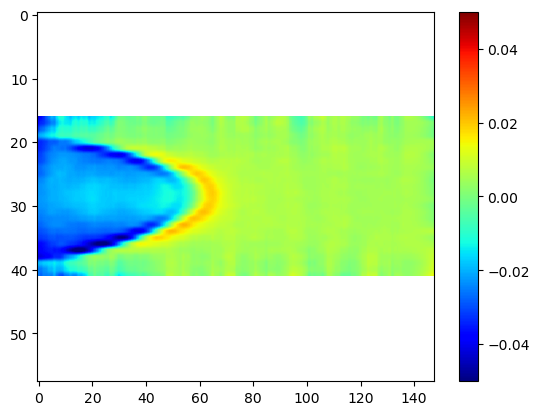

In [20]:
idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)
print(idx0, idx1)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

In [21]:
from scipy.interpolate import interp1d

def residuals(x):
    print(np.exp(x))
    kappa, gamma, rep00, rep01, rep02, K0 = np.exp(x)
    ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
    umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
    uu = umask[:-1,:,:]
    ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
    u = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
    pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

    p = pmask[60 * 20:-1:60,:,:,:]
    u = u[60 * 20:-1:60,:,:]
    mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
    #denom = (1 + (u / KK2)**nn) * (1 + (u / KK3)**nn)
    #mdslrho = ( (1 + KK2**nn) * (u / KK2)**nn / p[:,:,:,2] / (1 + (p[:,:,:,1]/K)**n) - (1 + KK3**nn) * (u / KK3)**nn / p[:,:,:,3] ) / denom * 60 * 10
    #r2 = (1 + KK2**nn) * (u / KK2)**nn / (1 + (u / KK2)**nn) / p[:,:,:,2] / (1 + (p[:,:,:,1]/K)**n)
    #r3 = (1 + KK3**nn) * (u / KK3)**nn / (1 + (u / KK3)**nn) / p[:,:,:,3]
    #r2 = hill(u, KK2, nn) / hill(1, KK2, nn) / (1 + (p[:,:,:,1]/K)**n) / p[:,:,:,2]
    #r3 = hill(u, KK3, nn) / hill(1, KK3, nn) / p[:,:,:,3]
    #mdslrho = (r2 - r3) * 60 * 10
    idx0 = int(8 * 60 * 60 // dt // 60)
    tidx0 = idx0 + 20
    tidx1 = int(36 * 60 * 60 // dt // 60)
    resid = mdslrho[:,int(nx//2),:] - dslrho[tidx0:tidx1,int(nx//2),:]
    #resid = mdslrho - dslrho[tidx0:tidx1,:,:]
    idx = np.isfinite(np.array(resid))
    resid = resid[idx].ravel()
    mse = np.mean(resid*resid)
    print(f'mse = {mse}')
    return resid
    #return mse

In [22]:
from scipy.optimize import least_squares, fmin, minimize

rep00,rep01,rep02 = 5,1e-3,1e-3
alpha0,alpha1,alpha2,alpha3 = 1,1,1,1
alpha = 1
beta0,beta1,beta2 = 0,0,0 # 1e-3,1e-3,1e-3
K1,K2,K3 = 1e2,1e2,1e2
K = 1
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 2
nn = 1
#kappa = 1e-14
gamma = 1
gamma_fp = np.log(2) / (12 * 60 * 60)
gamma_repr = np.log(2) / (1 * 60 * 60)
dx = 16e-6
dt = 10
t0 = 0

#ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
#umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
#uu = umask[:-1,:,:]

rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])  

#kappa, rep00, rep01, rep02,K,gamma_repr,KK0,KK1,KK2,KK3,nn = [1.90477568e-13, 2.40914790e-02, 1.23843785e+00, 3.67041049e+03, 2.42493865e+03, 2.92348718e-04, 4.55484789e-01, 3.22305581e-01, 2.66946556e-01, 2.84130169e-01, 6.74474278e+00]
#kappa,gamma,rep00, rep01, rep02,K,gamma_repr,KK0, KK1, KK2, KK3, nn = [1.46369824e-13, 5.41780938e+00, 2.41599534e+02, 1.02036301e+03, 4.45643474e+00, 1.71248412e+03, 3.20572744e-04, 2.29179548e-01, 3.54992148e-02, 4.78930529e-02, 4.24058609e-02, 9.59379329e+00]
#_,kappa,gamma,rep00, rep01, rep02,K,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single.npy')
#alpha0, alpha1, alpha2, alpha3, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.load('xopt_single_iptg_alpha_no_Ks.npy')
#kappa,gamma,rep00, rep01, rep02,K0,K1,K2,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_iptg.npy')
kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')
kappa, gamma, rep00, rep01, rep02, K0 = np.load('xopt_single_iptg_balanced.npy')
K1,K2 = K,K
#lb = [1e-14, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, gamma_repr/10, 1e-6, 1e-6, 1e-6, 1e-6]
#ub = [1e-12, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, gamma_repr*10, 1e6, 1e6, 1e6, 1e6]
lb = [1e-16] + [1e-6] * 5
ub = [1e-12] + [1e6] * 5
bounds = np.log([lb,ub])
res = least_squares(residuals, np.log([kappa, gamma, rep00, rep01, rep02, K0]), bounds=bounds, ftol=1e-3)

[2.33511623e-13 1.33472922e+01 1.12596688e+05 4.94426057e+04
 6.59301198e+04 4.88050445e+03]
14940
10080
mse = 5.810762379531442e-05
[2.33511522e-13 1.33472922e+01 1.12596688e+05 4.94426057e+04
 6.59301198e+04 4.88050445e+03]
14940
10080
mse = 5.810757248942164e-05
[2.33511623e-13 1.33472927e+01 1.12596688e+05 4.94426057e+04
 6.59301198e+04 4.88050445e+03]
14940
10080
mse = 5.810762082629815e-05
[2.33511623e-13 1.33472922e+01 1.12596708e+05 4.94426057e+04
 6.59301198e+04 4.88050445e+03]
14940
10080
mse = 5.810762057786361e-05
[2.33511623e-13 1.33472922e+01 1.12596688e+05 4.94426136e+04
 6.59301198e+04 4.88050445e+03]
14940
10080
mse = 5.810762353336084e-05
[2.33511623e-13 1.33472922e+01 1.12596688e+05 4.94426057e+04
 6.59301307e+04 4.88050445e+03]
14940
10080
mse = 5.810762654123136e-05
[2.33511623e-13 1.33472922e+01 1.12596688e+05 4.94426057e+04
 6.59301198e+04 4.88050507e+03]
14940
10080
mse = 5.8107622719394446e-05
[2.32764027e-13 1.83514784e+01 1.31112689e+05 5.24639088e+04
 6.2924

In [23]:
print(res)
print(np.exp(res.x))
print(np.log(2) / gamma_repr / 60)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.095e-04 -5.662e-03 ... -9.565e-03 -1.019e-02]
           x: [-2.916e+01  2.670e+00  1.179e+01  1.086e+01  1.110e+01
                8.568e+00]
        cost: 0.08699682594722535
         jac: [[-4.587e-07  1.174e-06 ... -4.308e-02 -9.110e-03]
               [-6.737e-05  9.704e-05 ... -4.305e-02 -9.167e-03]
               ...
               [ 2.116e-08 -6.414e-08 ... -1.305e-07  2.212e-07]
               [ 3.034e-10 -2.703e-09 ... -1.284e-07  2.106e-07]]
        grad: [-2.130e-03  9.539e-04 -3.597e-05 -3.527e-05 -4.653e-05
               -6.004e-06]
  optimality: 0.015724657781607632
 active_mask: [0 0 0 0 0 0]
        nfev: 8
        njev: 7
[2.15705292e-13 1.44382169e+01 1.32215996e+05 5.23079355e+04
 6.61438639e+04 5.26193179e+03]
51.89111730421959


In [33]:
np.save(f'xopt_{vector}_IPTG_{exp_date}_{scope_name}_pos{pos}.npy', np.exp(res.x))

In [24]:
np.exp(res.x)

array([2.15705292e-13, 1.44382169e+01, 1.32215996e+05, 5.23079355e+04,
       6.61438639e+04, 5.26193179e+03])

In [25]:
#alpha0,alpha1,alpha2,alpha3,rep00, rep01, rep02 = np.exp(res.x)
#alpha0, alpha1, alpha2, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.exp(res.x) #np.load('xopt_single_iptg_alpha_no_Ks.npy')
#kappa,gamma,rep00, rep01, rep02,K0,K1,K2,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_iptg.npy')
#kappa,gamma,rep00, rep01, rep02,K0,K1,K2,gamma_repr,KK0, KK1, KK2, KK3 = np.exp(res.x)
kappa, gamma, rep00, rep01, rep02, K0 = np.exp(res.x)
ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
pmask = solve_gene_expression(rep00, rep01, rep02, uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

print(np.nanmin(pmask))
print(pmask.shape)
p = pmask[60 * 20:-1:60,:,:,:]
mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])

14940
10080
32.22784120831362
(10081, 57, 58, 4)


In [26]:
print(f'K0,K1,K2 = {K0,K1,K2}')
print(f'KK0 = {KK0}')
print(f'KK1 = {KK1}')
print(f'KK2 = {KK2}')
print(f'KK3 = {KK3}')
print(f'nn = {nn}')
print(f'kappa, gamma = {kappa,gamma}')
print(f'rep0 = {rep00, rep01, rep02}')
print(f'Repressor half life = {np.log(2) / gamma_repr / 60} mins')


K0,K1,K2 = (5261.931792935089, 2678.665103943869, 2678.665103943869)
KK0 = 0.13153270028365505
KK1 = 0.0011859132237181818
KK2 = 0.001498556527152728
KK3 = 6.204467190457258e-05
nn = 15.682192315083379
kappa, gamma = (2.157052921846046e-13, 14.438216899984633)
rep0 = (132215.99613316072, 52307.93552148523, 66143.86393782703)
Repressor half life = 51.89111730421959 mins


In [27]:
print(K0/KK0)
print(K1/KK1)
print(K2/KK2)
print(nn / 4 * KK0 / K0)
print(nn / 4 * KK1 / K1)
print(nn / 4 * KK2 / K2)

40004.7424069265
2258736.179317975
1787496.8714282394
9.800208282536105e-05
1.7357264273132836e-06
2.193317449354897e-06


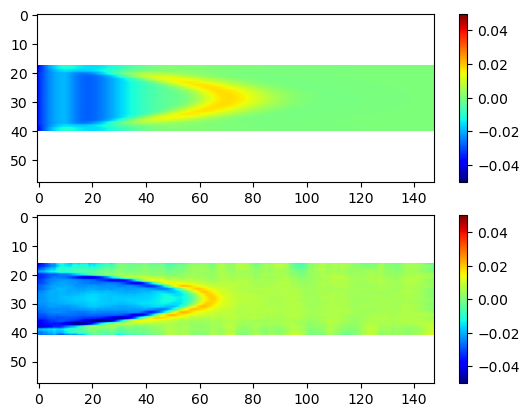

In [28]:
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

plt.subplot(2, 1, 2)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

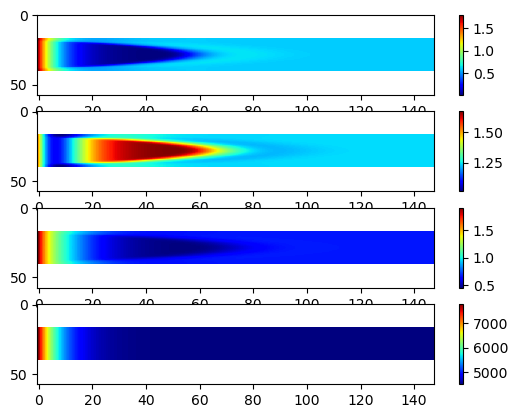

In [29]:
plt.subplot(4, 1, 1)
plt.imshow(p[:,int(nx//2),:,0].transpose() / K0, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 2)
plt.imshow(p[:,int(nx//2),:,1].transpose() / K1, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 3)
plt.imshow(p[:,int(nx//2),:,2].transpose() / K2, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 4)
plt.imshow(p[:,int(nx//2),:,3].transpose(), aspect='auto', cmap='jet')
plt.colorbar()

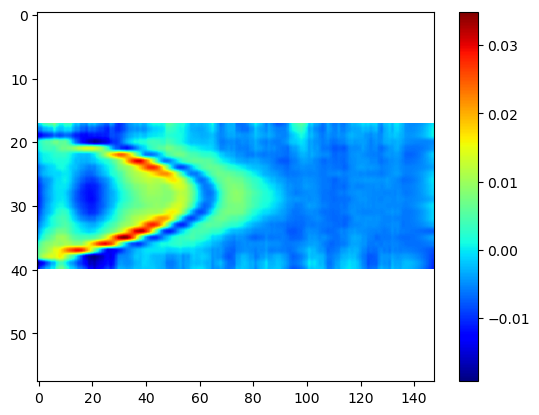

In [30]:
err = mdslrho[:,int(nx//2),:] - dslrho[idx0+20:idx1,int(nx//2),:]
plt.imshow(err.transpose(), aspect='auto', cmap='jet')
plt.colorbar()